3945 – Advanced Machine Learning, Spring 2022
# Home Assignment 1 – Unsupervised Learning

In this assignment, you will explore unsupervised learning techniques for clustering and dimensionality reduction, and apply them to the MNIST database of handwritten digits. Your task is to explore the use of clustering methods and dimensionality reduction techniques as steps preceding to classification.
You will submit a single ipython notebook (.ipynb) file that includes all the code and outputs, as well as a brief report that explains your approach and findings. You are encouraged to use methods and techniques covered in class but are also welcome to use any other relevant method you find suitable for the task.

Submission Guidelines

*  Submit the work in pairs. Only one submission for each pair.
*   Your submission should include a single zip file containing:
->  A single ipython notebook (.ipynb) file that includes all the code and outputs
-> A brief report (1-2 pages) in a pdf format that explains your approach and findings.
*   The submitted file should follow the naming convention: 3945_HW##_XXX_YYY.zip
->  the two hashtags are the assignment number
->  XXX and YYY are your student numbers (IDs) 
-> (For example: 3945_HW1_123456789_987654321.zip)
*   Make sure to run your notebook from start to finish before submitting to ensure that it runs without errors.
*   You may use external libraries. Specify all required libraries in a proper manner
*   Grading will be based on correctness, elegance of solution, and style (comments, naming conventions, etc.)
*   Your report should be clear, coherent, and concise
*  All figure and plots should include captions, labels and data units. Pay attention to data
*   Make sure to use correct ML methodologies and justify your selections (split the data to train/test, tune hyperparameters, report relevant performance measures).

In [ ]:
import numpy as np
import pandas as pandas
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.datasets import mnist
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Part 0: Load the data

### Pre-processing the data and undersamping to aid in run time on pixel level clustering and classification.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# flatten and normalize the data
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1) / 255.0
class_indices = [0, 1, 2, 3]  # Select classes 0, 1, 2, 3
n_samples = 5000  # Select 5000 samples per class

selected_train_images = []
selected_train_labels = []
selected_test_images = []
selected_test_labels = []

for class_idx in class_indices: # for each fo the selected classes

    # Get the indices of samples belonging to the current class
    class_indices = np.where(train_labels == class_idx)[0]

    # Select a random subset of samples from the current class
    selected_indices = np.random.choice(class_indices, n_samples // 2, replace=False)

    # Append the selected samples and labels to the output arrays
    selected_train_images.append(train_images_flat[selected_indices])
    selected_train_labels.append(train_labels[selected_indices])

    # Get the indices of test samples belonging to the current class
    class_indices = np.where(test_labels == class_idx)[0]

    # Select a random subset of test samples from the current class
    selected_indices = np.random.choice(class_indices, min(n_samples // 2, len(class_indices)), replace=False)

    # Append the selected test samples and labels to the output arrays
    selected_test_images.append(test_images_flat[selected_indices])
    selected_test_labels.append(test_labels[selected_indices])

# convert the output arrays to numpy arrays
selected_train_images = np.concatenate(selected_train_images, axis=0)
selected_train_labels = np.concatenate(selected_train_labels, axis=0)
selected_test_images = np.concatenate(selected_test_images, axis=0)
selected_test_labels = np.concatenate(selected_test_labels, axis=0)

11490434/11490434 [==============================] - 0s 0us/step


Explore the data briefly

X_train: (10000, 784)
Y_train: (10000,)
X_test:  (4157, 784)
Y_test:  (4157,)
There are 10000 images in the training set


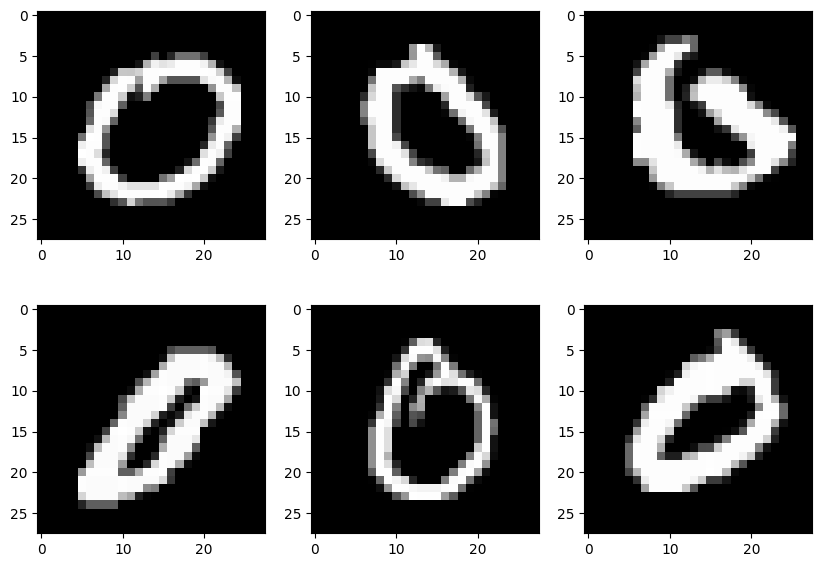

In [ ]:
print('X_train: ' + str(selected_train_images.shape))
print('Y_train: ' + str(selected_train_labels.shape))
print('X_test:  '  + str(selected_test_images.shape))
print('Y_test:  '  + str(selected_test_labels.shape))
print(f"There are {len(selected_train_images)} images in the training set")

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.flatten()
for i in range(6):  
  img = selected_train_images[i].reshape(28, 28)  # reshape flattened image to original shape
  axs[i].imshow(img, cmap='gray')
plt.show()

## Part 1: Clustering

For at least three different clustering methods of your choice perform:

1. Cluster the data using the raw pixel level values.
2. Evaluate the clustering result using standard evaluation metrics
3. Visualize the clusters by displaying a few images from each cluster.
4. Build a simple classifier based on the clustering results. Specifically, assign a label to each cluster (e.g., the most common digit in the cluster) and use this label to predict the digit of a test image based on its nearest cluster.
Note: You may suggest other methods to construct a classifier over the clustering results.
5. Evaluate the performance of the classifier.
6. Explore different parameters for the clustering and evaluate their effect on the results.

For convenience and code reusability, we define the following functions:

In [ ]:
def evaluate_cluster(selected_train_images, selected_train_labels, labels):
  silhouette_avg = silhouette_score(selected_train_images, labels)
  print("Silhouette Score:", silhouette_avg)

  hcv_scores = homogeneity_completeness_v_measure(selected_train_labels, labels)
  print("Homogeneity Score:", hcv_scores[0])
  print("Completeness Score:", hcv_scores[1])
  print("V-measure Score:", hcv_scores[2])

def visualize_clusters(selected_train_images, n_clusters=4):
  cluster_indices = {} # Create a dictionary to store the indices of the images in each cluster
  for i in range(n_clusters):
      cluster_indices[i] = np.where(labels == i)[0]

  fig, axs = plt.subplots(nrows=n_clusters, ncols=4, figsize=(10, 10))
  for i in range(n_clusters):

      # Get the indices of a random subset of images from the current cluster
      selected_indices = np.random.choice(cluster_indices[i], size=4, replace=False)

      for j, idx in enumerate(selected_indices):
          axs[i, j].imshow(selected_train_images[idx].reshape(28, 28), cmap='gray')
          axs[i, j].axis('off')
          if j == 0:
              axs[i, j].set_title(f'Cluster {i}')

  plt.tight_layout()
  plt.show()

def evaluate_classifer(selected_test_labels, test_digit_labels):
  accuracy = np.mean(test_digit_labels == selected_test_labels)
  print("Accuracy:", accuracy)

  precision = precision_score(selected_test_labels, test_digit_labels, average='macro')
  recall = recall_score(selected_test_labels, test_digit_labels, average='macro')
  print("Precision:", precision)
  print("Recall:", recall)

## Method 1: GMM

Cluster the data using the raw pixel level values

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42) # define 4 clusters
gmm.fit(selected_train_images) # Fit GMM to the normalized data

/usr/local/lib/python3.9/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


GaussianMixture(n_components=4, random_state=42)

Evaluate the clustering result using standard evaluation metrics

In [ ]:
labels = gmm.predict(selected_train_images) # extract the labels assigned by GMM
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.06694334616151072
Homogeneity Score: 0.46832135469878217
Completeness Score: 0.5013319333362575
V-measure Score: 0.4842647430187674


Visualize the clusters by displaying a few images from each cluster.

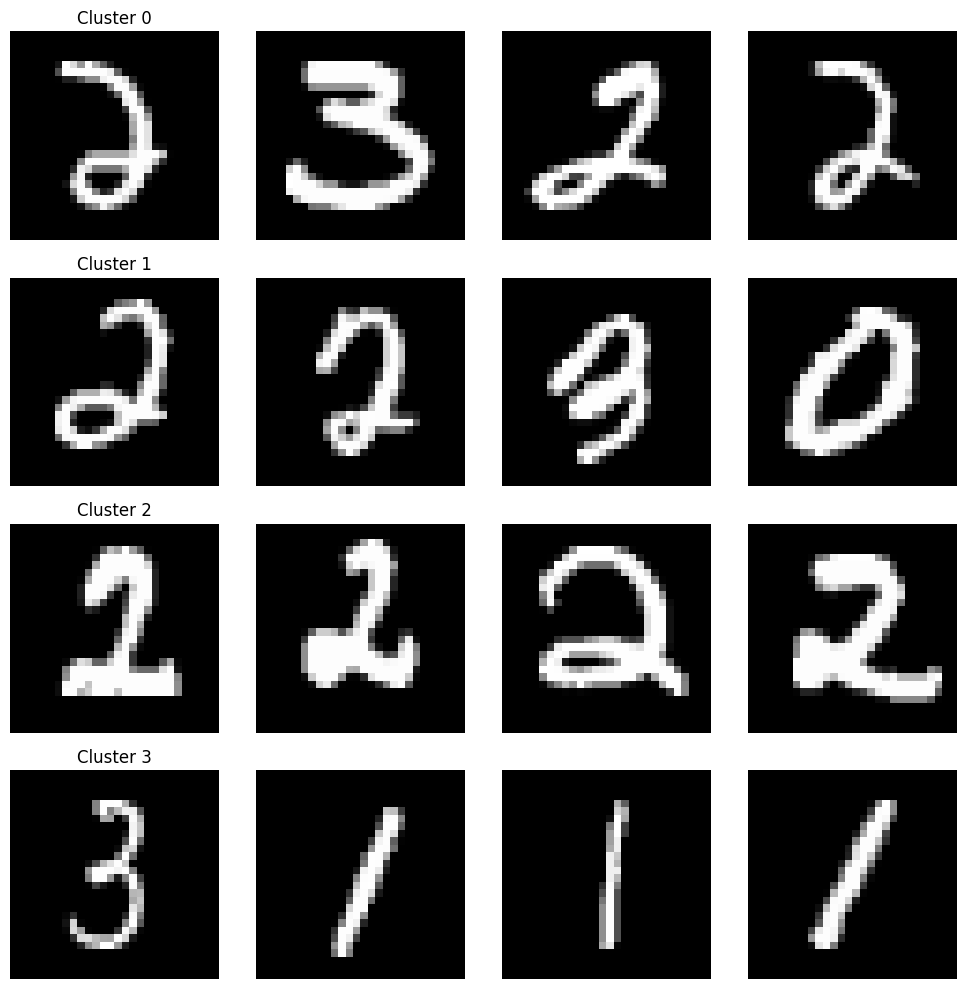

In [ ]:
visualize_clusters(selected_train_images, 4)

Build a simple classifier based on the clustering results.

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(selected_train_images, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Evaluate the performance of the classifier

In [ ]:
# Use the classifier to predict the digit of a test image based on its nearest cluster
test_cluster_labels = logreg.predict(selected_test_images)
test_digit_labels = [cluster_digit[label] for label in test_cluster_labels]

evaluate_classifer(selected_test_labels, test_digit_labels)

Accuracy: 0.7337021890786625
Precision: 0.7839541153922612
Recall: 0.7299048788231774


Explore different parameters for the clustering and evaluate their effect on the results.

In [ ]:
# Initialize Gaus Mixture with covariance_type = diag (each component has its own diagonal covariance matrix)
# Also the method to initialize params (weights, means, etc) are randomly selected data points 

gmm = GaussianMixture(n_components=4, random_state=42, covariance_type='diag', init_params='random_from_data') # define 4 clusters
gmm.fit(selected_train_images) # Fit GMM to the normalized data

labels = gmm.predict(selected_train_images) # extract the labels assigned by GMM
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.07299172648459597
Homogeneity Score: 0.23876294963521916
Completeness Score: 0.27378037663178084
V-measure Score: 0.25507545187620934


### Method 2: Agglomerative Clustering

Cluster the data using the raw pixel level values.

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative.fit(selected_train_images)

AgglomerativeClustering(n_clusters=4)

Evaluate the clustering result using standard evaluation metrics

In [ ]:
labels = agglomerative.labels_ # Get the labels assigned by Agglomerative clustering
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.10290505351900267
Homogeneity Score: 0.9242775394954078
Completeness Score: 0.9243368904759892
V-measure Score: 0.9243072140329474


Visualize the clusters by displaying a few images from each cluster.

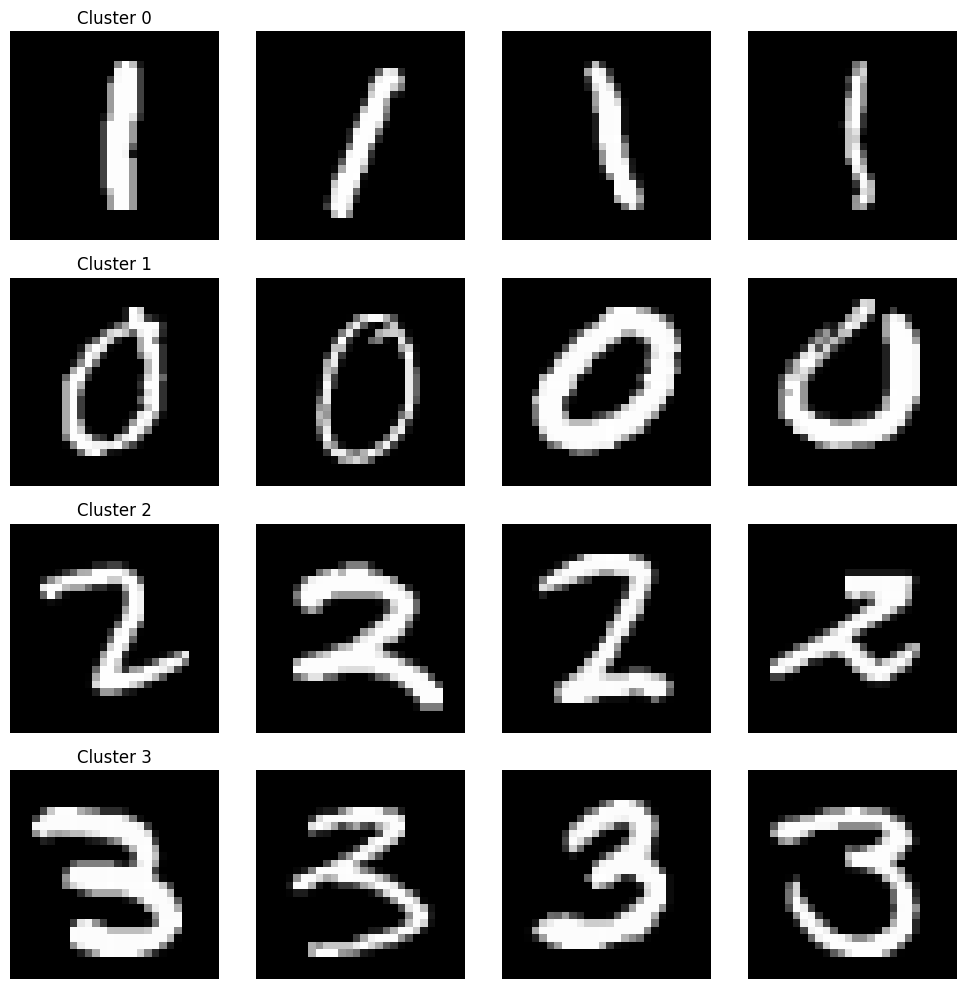

In [ ]:
visualize_clusters(selected_train_images, 4)

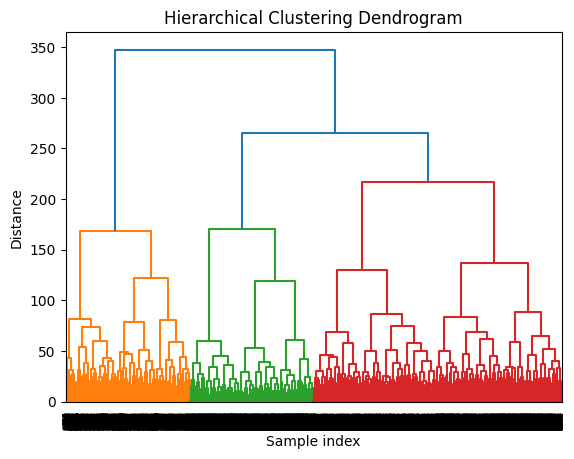

In [ ]:
# Plot dendrogram
linkage_matrix = linkage(selected_train_images, method='ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

Build a simple classifier based on the clustering results.

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(selected_train_images, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Evaluate the performance of the classifier.

In [ ]:
# Use the classifier to predict the digit of a test image based on its nearest cluster
test_cluster_labels = logreg.predict(selected_test_images)
test_digit_labels = [cluster_digit[label] for label in test_cluster_labels]

evaluate_classifer(selected_test_labels, test_digit_labels)

Accuracy: 0.9704113543420736
Precision: 0.9699676952714029
Recall: 0.9699969907688066


Explore different parameters for the clustering and evaluate their effect on the results.

In [ ]:
# Initialize with linkage criterion set to 'complete' and metric set to manhattan

agglomerative = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='manhattan')
agglomerative.fit(selected_train_images)

labels = agglomerative.labels_ # Get the labels assigned by Agglomerative clustering
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.10784428605857405
Homogeneity Score: 0.3532468520115983
Completeness Score: 0.5801700093842599
V-measure Score: 0.43912476391320227


### Method 2: K Means 

Cluster the data using the raw pixel level values.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(selected_train_images)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

Evaluate the clustering result using standard evaluation metrics

In [ ]:
labels = kmeans.labels_
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.11946480096159458
Homogeneity Score: 0.6530546626088765
Completeness Score: 0.6560109528689537
V-measure Score: 0.6545294696128509


Visualize the clusters by displaying a few images from each cluster.

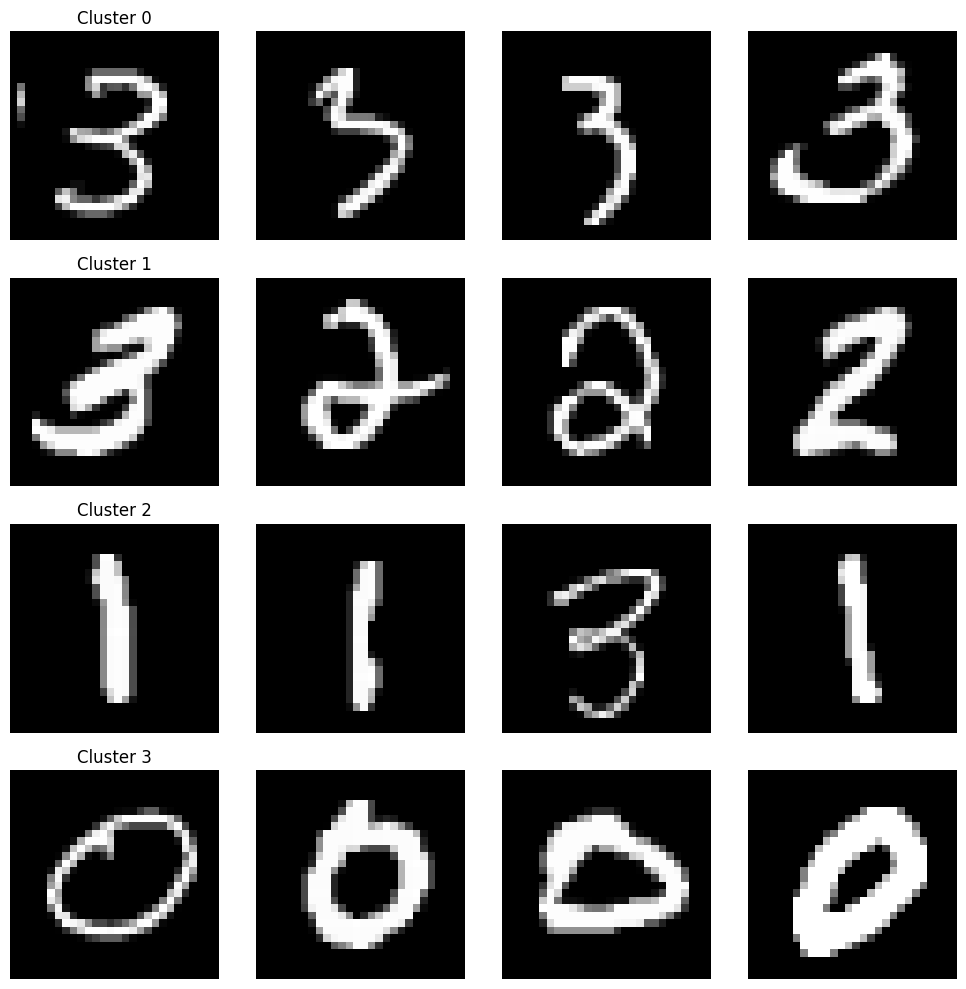

In [ ]:
visualize_clusters(selected_train_images, 4)

Build a simple classifier based on the clustering results.

In [ ]:
# Train a logistic regression classifier on the cluster labels
logreg = LogisticRegression(random_state=42)
logreg.fit(selected_train_images, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Evaluate the performance of the classifier.

In [ ]:
test_cluster_labels = logreg.predict(selected_test_images)
test_digit_labels = [cluster_digit[label] for label in test_cluster_labels]

evaluate_classifer(selected_test_labels, test_digit_labels)

Accuracy: 0.8710608611979793
Precision: 0.8767568562268385
Recall: 0.8687340527100428


Explore different parameters for the clustering and evaluate their effect on the results.

In [ ]:
# Initilize with k means algorithm different from default (lloyd) and random initialize of centroids
kmeans = KMeans(n_clusters=4, random_state=42, init="random", algorithm="elkan")
kmeans.fit(selected_train_images)

labels = kmeans.labels_
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.11946480096159458
Homogeneity Score: 0.6530546626088766
Completeness Score: 0.6560109528689537
V-measure Score: 0.6545294696128507


### Method 4: Mini Batch K Means

Cluster the data using the raw pixel level values.

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=256)
kmeans.fit(selected_train_images)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=256, n_clusters=4, random_state=42)

Evaluate the clustering result using standard evaluation metrics

In [ ]:
labels = kmeans.labels_
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

Silhouette Score: 0.10242395632371992
Homogeneity Score: 0.44307530381964255
Completeness Score: 0.46357715217071677
V-measure Score: 0.453094427053687


Visualize the clusters by displaying a few images from each cluster.

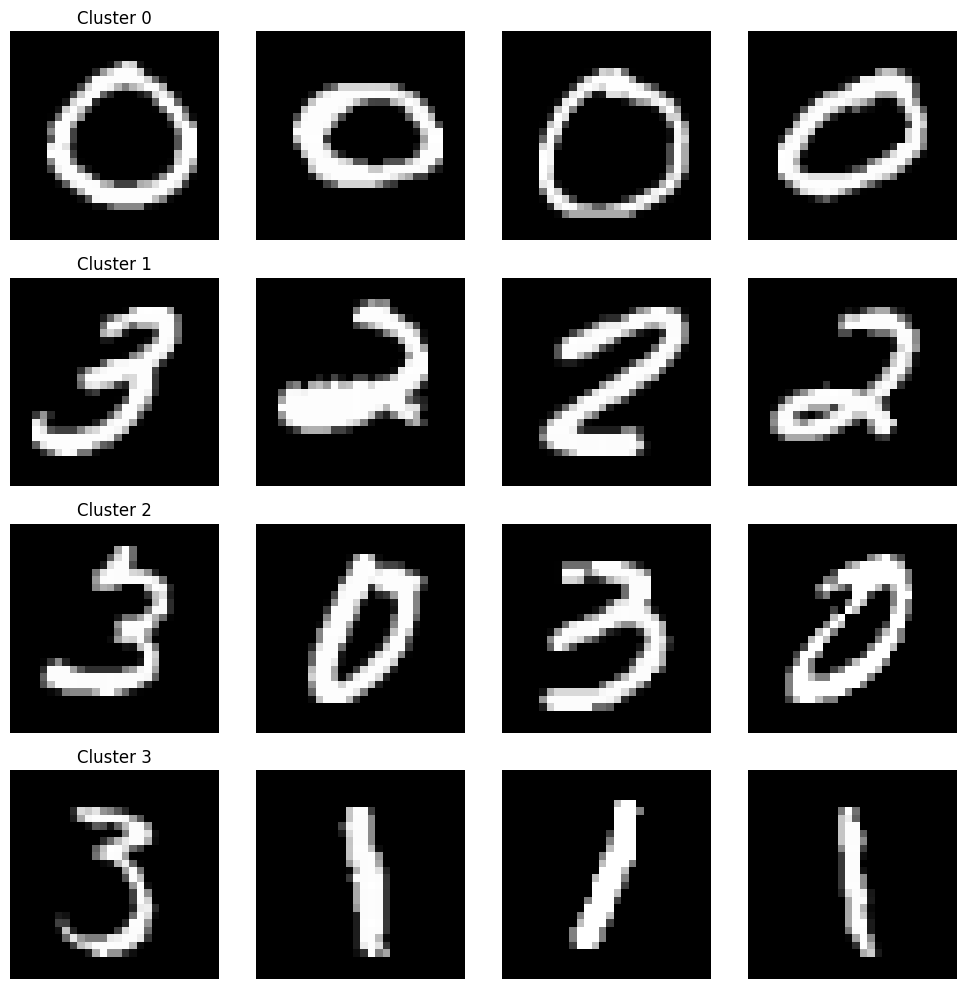

In [ ]:
visualize_clusters(selected_train_images, 4)

Build a simple classifier based on the clustering results.

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(selected_train_images, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Evaluate the performance of the classifier.

In [ ]:
test_cluster_labels = logreg.predict(selected_test_images)
test_digit_labels = [cluster_digit[label] for label in test_cluster_labels]

evaluate_classifer(selected_test_labels, test_digit_labels)

Accuracy: 0.6612942025499158
Precision: 0.5052421993211467
Recall: 0.6570620656827427


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Explore different parameters for the clustering and evaluate their effect on the results.

In [ ]:
# Initilize with random initialize of centroids

kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=256, init="random")
kmeans.fit(selected_train_images)
labels = kmeans.labels_
cluster_digit = {cluster: np.argmax(np.bincount(selected_train_labels[labels == cluster])) for cluster in range(4)}

evaluate_cluster(selected_train_images, selected_train_labels, labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.09614405273549255
Homogeneity Score: 0.6042084339263825
Completeness Score: 0.6078311313431758
V-measure Score: 0.6060143686462636


## Part 2: Dimensionality Reduction

For at least three different dimensionality reduction methods of your choice perform:
1. Reduce the dimensionality of the data and visualize the first few features in the new space.
2. Train at least one classifier on the data in the new space.
3. Evaluate the performance of the classifiers
4. Explore different parameters for the dimensionality reduction and evaluate their effect on the results.

For convenience and code reusability, we define the following functions:

In [ ]:
# Load the MNIST dataset again (to ensure clean data)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# flatten and normalize the data
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1) / 255.0

def plot_logreg_misclassified(test_images, test_labels, logreg_preds, logreg_misclassified):
  plt.figure(figsize=(10,10))
  for i, idx in enumerate(logreg_misclassified[:25]):
      plt.subplot(5, 5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(test_images[idx], cmap=plt.cm.binary)
      plt.xlabel('Predicted: {}, Actual: {}'.format(logreg_preds[idx], test_labels[idx]))
  plt.suptitle('Misclassified images by logistic regression classifier')
  plt.show()

def plot_knn_misclassified(test_images, test_labels, knn_preds, knn_misclassified):
  plt.figure(figsize=(10,10))
  for i, idx in enumerate(knn_misclassified[:25]):
      plt.subplot(5, 5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(test_images[idx], cmap=plt.cm.binary)
      plt.xlabel('Predicted: {}, Actual: {}'.format(knn_preds[idx], test_labels[idx]))
  plt.suptitle('Misclassified images by KNN classifier')
  plt.show()

def evaluate_classifiers(logreg, knn, test_images, test_labels):
  print('Accuracy of logistic regression classifier: {:.2f}'.format(logreg.score(test_images, test_labels)))
  print('Accuracy of KNN classifier: {:.2f}'.format(knn.score(test_images, test_labels)))


### Method 1: PCA

Reduce the dimensionality of the data and visualize the first few features in the new space.

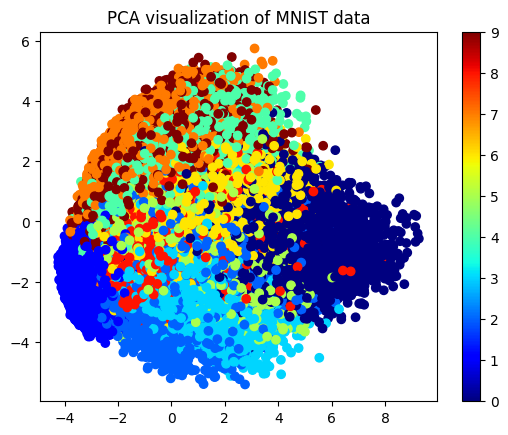

In [ ]:
pca = PCA(n_components=2, random_state=42)
train_images_pca = pca.fit_transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

plt.scatter(train_images_pca[:, 0], train_images_pca[:, 1], c=train_labels, cmap='jet')
plt.title('PCA visualization of MNIST data')
plt.colorbar()
plt.show()

Train at least one classifier on the data in the new space.

In [ ]:
# Train a logistic regression classifier on the data
logreg = LogisticRegression(random_state=42)
logreg.fit(train_images_pca, train_labels)

# Train a KNN classifier on the data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_images_pca, train_labels)

KNeighborsClassifier()

Evaluate the performance of the classifiers

In [ ]:
evaluate_classifiers(logreg, knn, test_images_pca, test_labels)

Accuracy of logistic regression classifier: 0.45
Accuracy of KNN classifier: 0.42


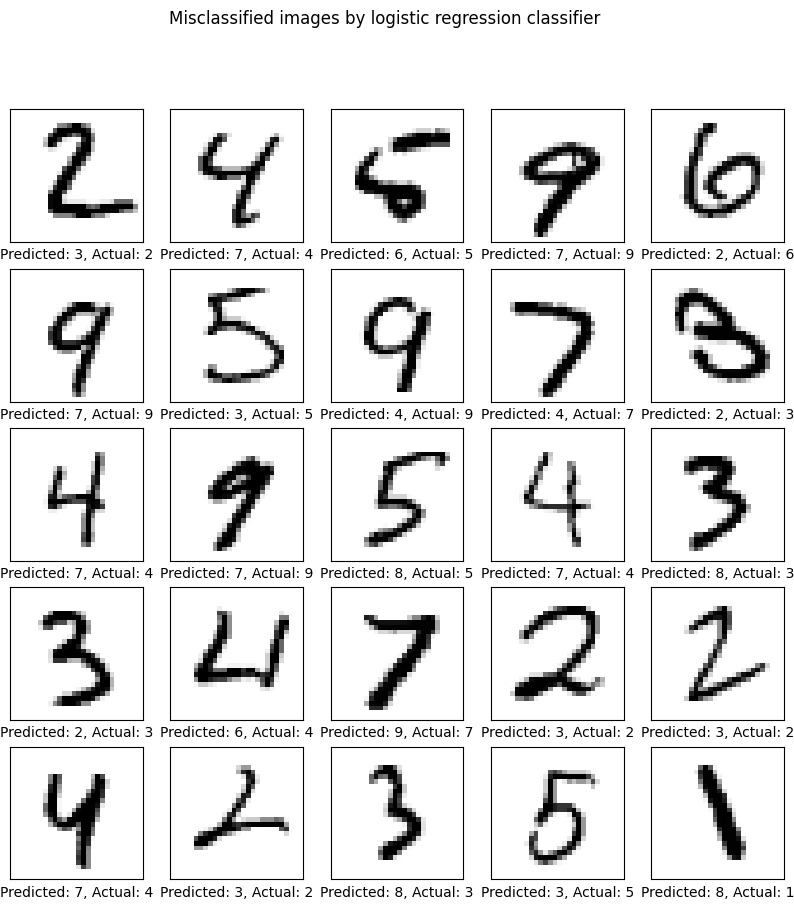

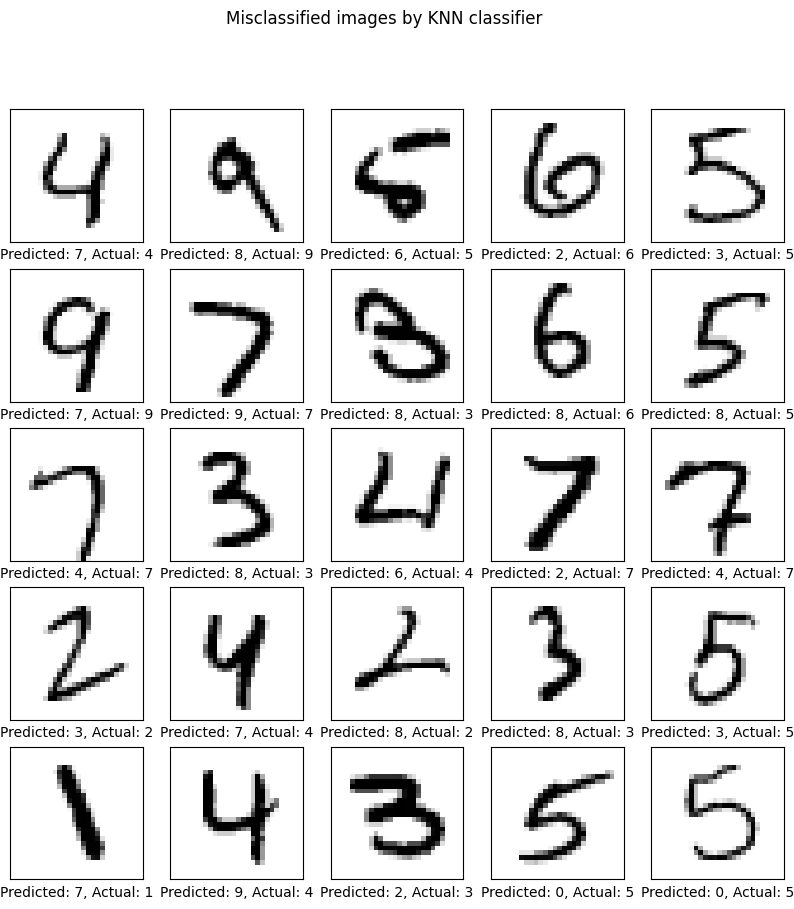

In [ ]:
# Get the misclassified indices for logistic regression
logreg_preds = logreg.predict(test_images_pca)
logreg_misclassified = np.where(logreg_preds != test_labels)[0]

plot_logreg_misclassified(test_images, test_labels, logreg_preds, logreg_misclassified)

# Get the misclassified indices for KNN
knn_preds = knn.predict(test_images_pca)
knn_misclassified = np.where(knn_preds != test_labels)[0]

plot_knn_misclassified(test_images, test_labels, knn_preds, knn_misclassified)

Explore different parameters for the dimensionality reduction and evaluate their effect on
the results.

In [ ]:
# Initialize to set whitening to true
pca = PCA(n_components=2, random_state=42, whiten=True)
train_images_pca = pca.fit_transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

# Train a logistic regression classifier on the data
logreg = LogisticRegression(random_state=42)
logreg.fit(train_images_pca, train_labels)

# Train a KNN classifier on the data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_images_pca, train_labels)

evaluate_classifiers(logreg, knn, test_images_pca, test_labels)

Accuracy of logistic regression classifier: 0.45
Accuracy of KNN classifier: 0.42


### Method 2: t-SNE

Reduce the dimensionality of the data and visualize the first few features in the new space.

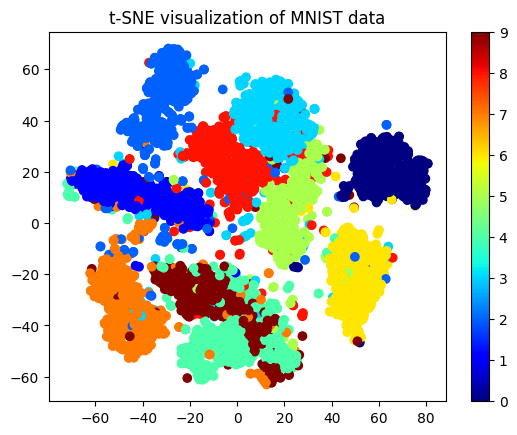

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Subsample the data for faster run time
train_images = train_images[:5000]
train_labels = train_labels[:5000]
test_images = test_images[:1000]
test_labels = test_labels[:1000]

# Reshape the data into a flattened 1D array
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

# Reduce the dimensionality of the data using t-SNE and visualize the first few features
tsne = TSNE(n_components=2, random_state=42)
train_images_tsne = tsne.fit_transform(train_images_flat)
test_images_tsne = tsne.fit_transform(test_images_flat)

plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels, cmap='jet')
plt.title('t-SNE visualization of MNIST data')
plt.colorbar()
plt.show()

Train at least one classifier on the data in the new space.

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(train_images_tsne, train_labels)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_images_tsne, train_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNeighborsClassifier()

Evaluate the performance of the classifiers

In [ ]:
evaluate_classifiers(logreg, knn, test_images_tsne, test_labels)

Accuracy of logistic regression classifier: 0.13
Accuracy of KNN classifier: 0.20


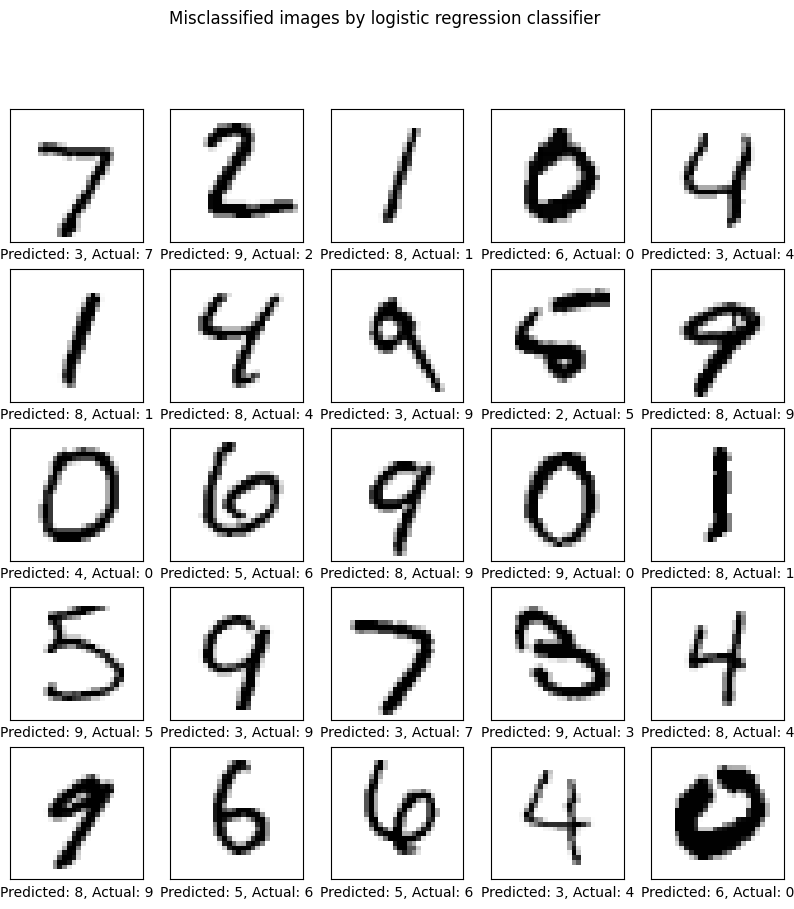

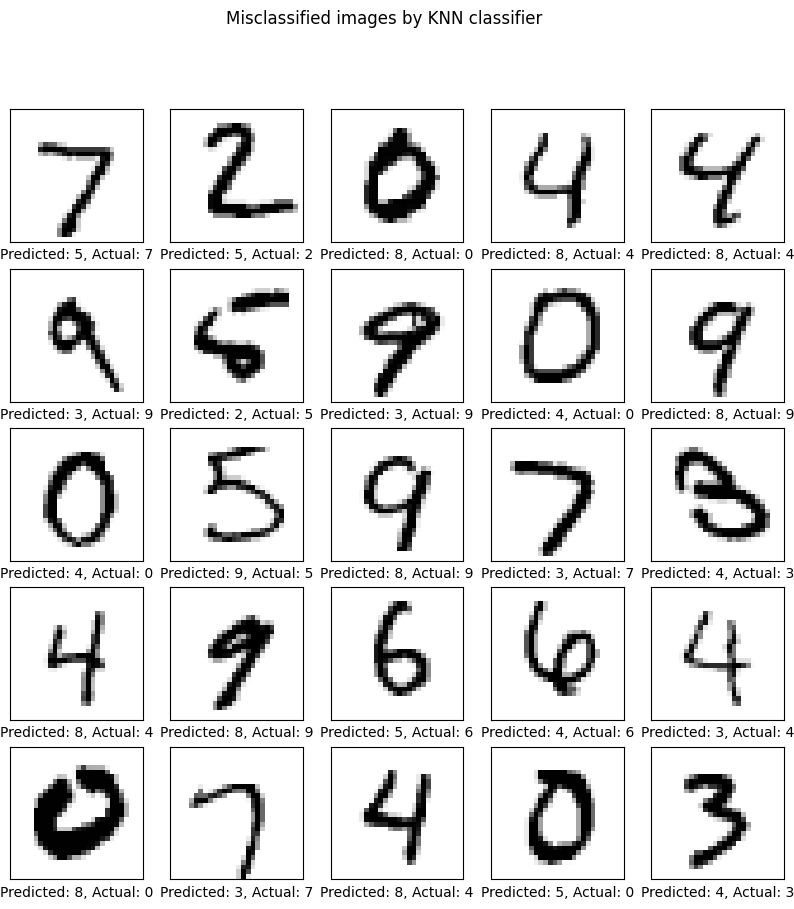

In [ ]:
logreg_preds = logreg.predict(test_images_tsne)
logreg_misclassified = np.where(logreg_preds != test_labels)[0]
plot_logreg_misclassified(test_images, test_labels, logreg_preds, logreg_misclassified)

knn_preds = knn.predict(test_images_tsne)
knn_misclassified = np.where(knn_preds != test_labels)[0]
plot_knn_misclassified(test_images, test_labels, knn_preds, knn_misclassified)

### Method 3: UMAP

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=88a4dd7b9c6f9e95659c245263be9e8b87ba7c3a7058a064e56165c3fdff74fa
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=c14283a99213b2e0fa50598531fc083bc882ab6e50f86fc4fda5030a3c93470a
  Stored in directory: /root/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent


In [ ]:
import umap

Reduce the dimensionality of the data and visualize the first few features in the new space.

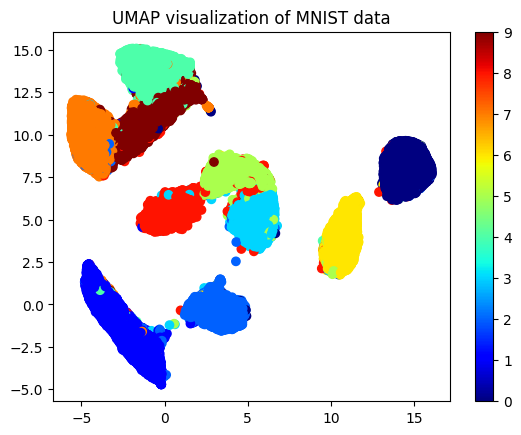

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images_flat = train_images.reshape((train_images.shape[0], -1))
test_images_flat = test_images.reshape((test_images.shape[0], -1))

umap_reducer = umap.UMAP(n_components=2, random_state=42)
train_images_umap = umap_reducer.fit_transform(train_images_flat)
test_images_umap = umap_reducer.transform(test_images_flat)

plt.scatter(train_images_umap[:, 0], train_images_umap[:, 1], c=train_labels, cmap='jet')
plt.title('UMAP visualization of MNIST data')
plt.colorbar()
plt.show()

Train at least one classifier on the data in the new space.

In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(train_images_umap, train_labels)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_images_umap, train_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNeighborsClassifier()

Evaluate the performance of the classifiers

In [ ]:
evaluate_classifiers(logreg, knn, test_images_umap, test_labels)

Accuracy of logistic regression classifier: 0.93
Accuracy of KNN classifier: 0.95


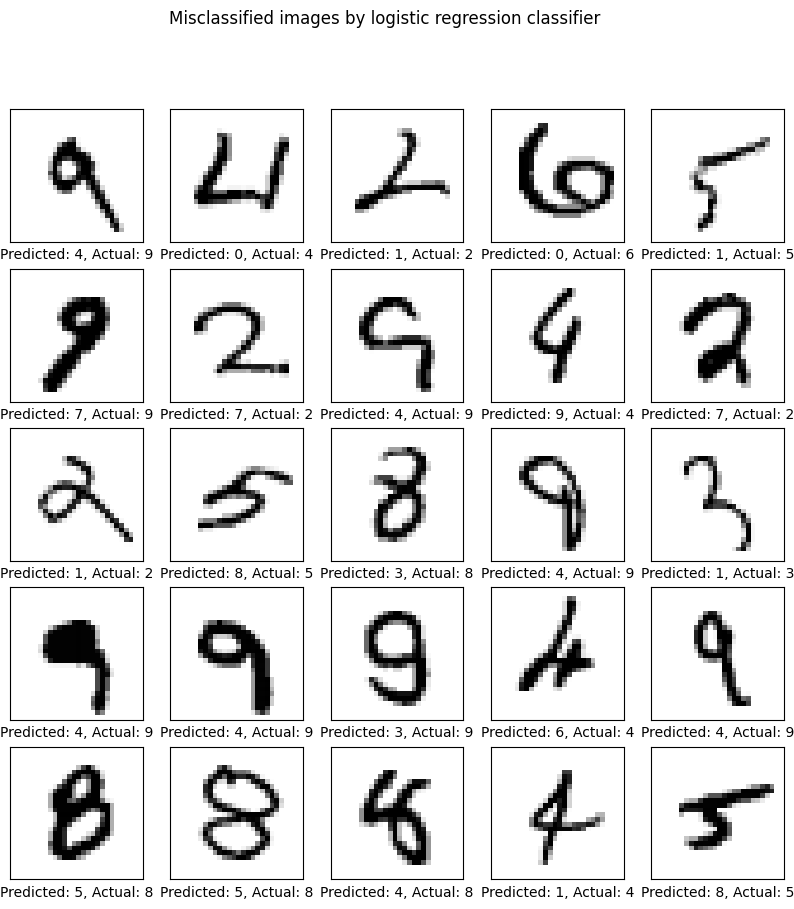

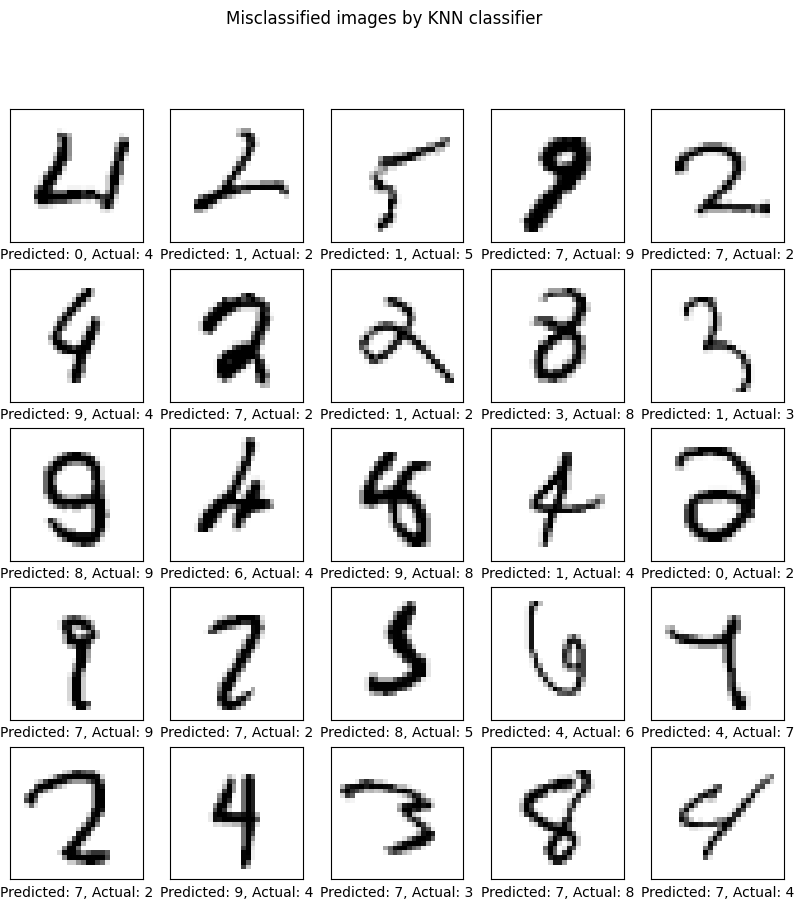

In [ ]:
logreg_preds = logreg.predict(test_images_umap)
logreg_misclassified = np.where(logreg_preds != test_labels)[0]
plot_logreg_misclassified(test_images, test_labels, logreg_preds, logreg_misclassified)

knn_preds = knn.predict(test_images_umap)
knn_misclassified = np.where(knn_preds != test_labels)[0]
plot_knn_misclassified(test_images, test_labels, knn_preds, knn_misclassified)

## Part 4: Classification of the raw data

For at least one classification algorithm of your choice:
1. Train a classifier on the raw pixel level values.
2. Explore different parameters for the classification model
3. Evaluate the results of the model

Train a classifier on the raw pixel level vaues

Epoch 1/10
422/422 [==============================] - 27s 41ms/step - loss: 0.2665 - accuracy: 0.9199 - val_loss: 0.0967 - val_accuracy: 0.9708
Epoch 2/10
422/422 [==============================] - 11s 25ms/step - loss: 0.1070 - accuracy: 0.9669 - val_loss: 0.0860 - val_accuracy: 0.9730
Epoch 3/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0759 - accuracy: 0.9758 - val_loss: 0.0714 - val_accuracy: 0.9777
Epoch 4/10
422/422 [==============================] - 9s 22ms/step - loss: 0.0576 - accuracy: 0.9815 - val_loss: 0.0562 - val_accuracy: 0.9817
Epoch 5/10
422/422 [==============================] - 10s 23ms/step - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0708 - val_accuracy: 0.9795
Epoch 6/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0403 - accuracy: 0.9871 - val_loss: 0.0701 - val_accuracy: 0.9805
Epoch 7/10
422/422 [==============================] - 10s 24ms/step - loss: 0.0361 - accuracy: 0.9881 - val_loss: 0.0664 - val_accuracy: 

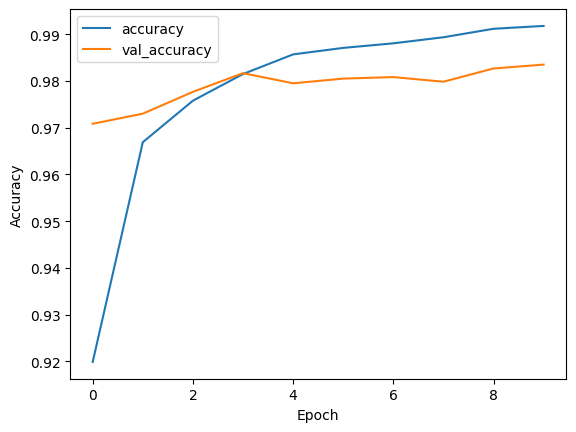

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluate the results of the model

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
print('Accuracy:', np.mean(y_pred == y_true))
print('Classification report:\n', classification_report(y_true, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))

313/313 [==============================] - 1s 4ms/step
Accuracy: 0.9827
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:
 [[ 971    1    2    1    0    2    1    1    1    0]
 [   0 1130    2    0    0    2    0    1    0    0]
 [   1    0 1015    

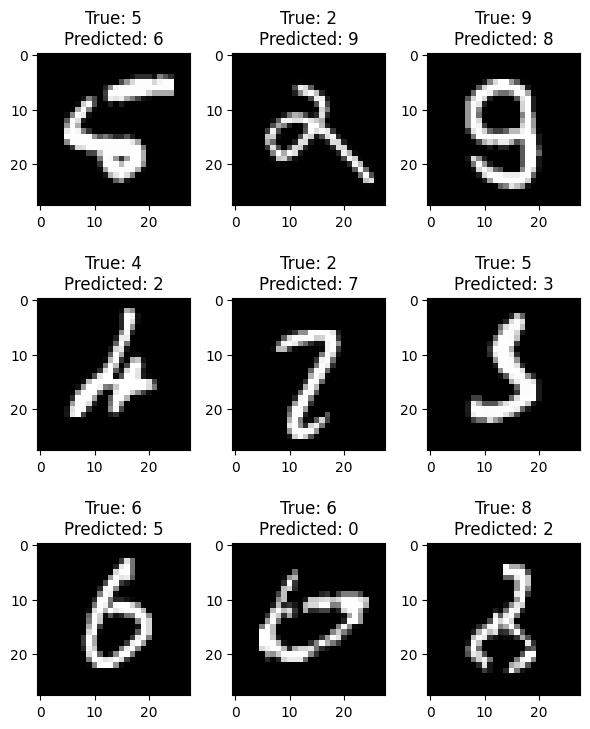

In [ ]:
misclassified_idx = np.where(y_pred != y_true)[0]
num_rows, num_cols = 3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2.5*num_rows))
for i, idx in enumerate(misclassified_idx[:num_rows*num_cols]):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(X_test[idx].reshape(28,28), cmap='gray')
    ax.set_title(f'True: {y_true[idx]}\nPredicted: {y_pred[idx]}')
plt.tight_layout()
plt.show()

Explore different parameters for the classification model

Epoch 1/20
844/844 [==============================] - 8s 9ms/step - loss: 0.4837 - accuracy: 0.8506 - val_loss: 0.1355 - val_accuracy: 0.9573
Epoch 2/20
844/844 [==============================] - 8s 9ms/step - loss: 0.2403 - accuracy: 0.9308 - val_loss: 0.1018 - val_accuracy: 0.9717
Epoch 3/20
844/844 [==============================] - 6s 8ms/step - loss: 0.1903 - accuracy: 0.9444 - val_loss: 0.0882 - val_accuracy: 0.9735
Epoch 4/20
844/844 [==============================] - 8s 9ms/step - loss: 0.1678 - accuracy: 0.9511 - val_loss: 0.0799 - val_accuracy: 0.9765
Epoch 5/20
844/844 [==============================] - 7s 8ms/step - loss: 0.1498 - accuracy: 0.9558 - val_loss: 0.0757 - val_accuracy: 0.9780
Epoch 6/20
844/844 [==============================] - 7s 9ms/step - loss: 0.1323 - accuracy: 0.9600 - val_loss: 0.0812 - val_accuracy: 0.9778
Epoch 7/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1258 - accuracy: 0.9628 - val_loss: 0.0707 - val_accuracy: 0.9790
Epoch 

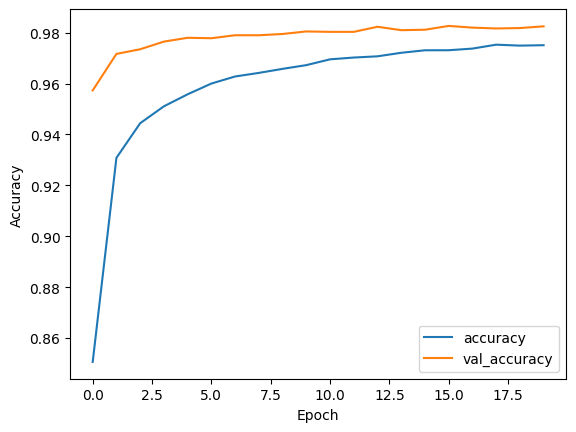


313/313 [==============================] - 1s 3ms/step
Accuracy: 0.9806
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:
 [[ 973    1    1    0    0    1    2    1    1    0]
 [   0 1128    1    1    0    0    2    0    3    0]
 [   3    2 1011   

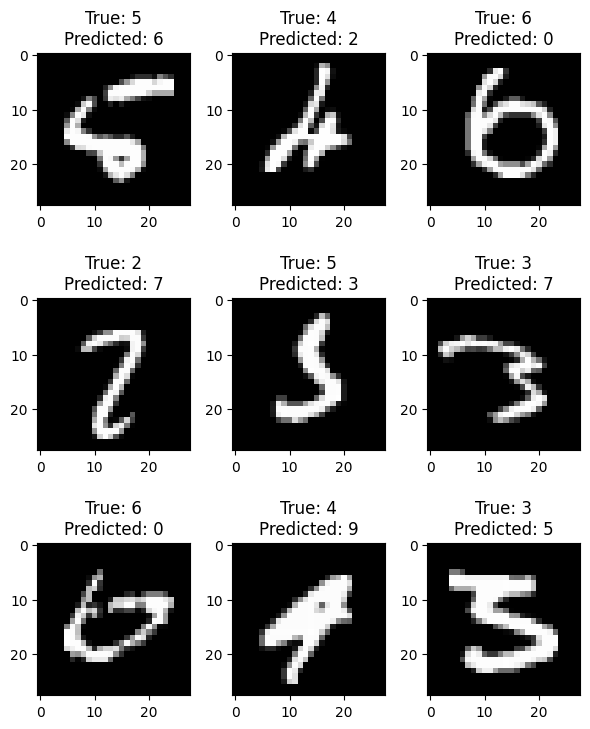

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model = keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print()

y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
print('Accuracy:', np.mean(y_pred == y_true))
print('Classification report:\n', classification_report(y_true, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))

misclassified_idx = np.where(y_pred != y_true)[0]
num_rows, num_cols = 3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2.5*num_rows))
for i, idx in enumerate(misclassified_idx[:num_rows*num_cols]):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(X_test[idx].reshape(28,28), cmap='gray')
    ax.set_title(f'True: {y_true[idx]}\nPredicted: {y_pred[idx]}')
plt.tight_layout()
plt.show()